In [1]:
import sys  
sys.path.insert(1, "..")
from hfsp_scripts import hfsp_functions as hfsp
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
from scipy import optimize
import networkx as nx
import pandas as pd

# Define variables for FT1

In [4]:
temp_sch_1wC = np.array([168])
temp_sch_2wC = np.array([336])
temp_sch_4wC = np.array([672])
temp_sch_1wCW = np.array([20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,8])
temp_sch_2wCW = np.array([20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,16])
temp_sch_4wCW = np.array([20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,
                          20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,12])
temp_sch_2wC_8hW = np.array([336,8])
temp_sch_2wC_24hW = np.array([336,24])
temp_sch_2wC_72hW = np.array([336,72])
      

# manual prediction/fitting from Rishi's data

p_c = 0.0003
p_w = 0.015
p_e = 1
p_d = 0

# Define g = the SAM template and also define the initial state.

In [11]:
T_3d = hfsp.create_tissue("../inputs/3d_sam.csv", True)
g = T_3d

# Initial state is alomost 0.94% active nodes (value 10WSD) == around 8 random cells activated in a 3D template.

TENwSD_state = np.concatenate((np.zeros(len(g.nodes()), dtype = int) , np.zeros(len(g.edges()), dtype = int)))
TENwSD_state[0] = 1
TENwSD_state[100] = 1
TENwSD_state[200] = 1
TENwSD_state[300] = 1
TENwSD_state[400] = 1
TENwSD_state[500] = 1
TENwSD_state[600] = 1
TENwSD_state[700] = 1
TENwSD_state[800] = 1

hfsp.update_spontaneous(g, jump_state = TENwSD_state)

# Ok, now TENwSD_state is a random state with 0.93% active nodes

In [13]:
g.edges[(1955, 2032)]["edge_state"]

0

In [24]:
hfsp.update_spontaneous(g, jump_state = TENwSD_state)
trj = hfsp.trajectory(g, temp_sch = temp_sch_4wC, p_decay = p_d , p_cold = p_c , p_warm = p_w, p_edge = 0.001, 
                   rule_code_node = [1,0.5], rule_code_edge = 0)

In [25]:
trj

,time,% of active nodes,% of active edges,2050,2054,4104,2062,4111,2065,2066,...,"(4048, 4797)","(4057, 4807)","(4057, 4089)","(4058, 4070)","(2014, 2031)","(2014, 2016)","(4064, 4248)","(2032, 2033)","(2036, 2039)","(4095, 4797)"
0,0,1.055100,0.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1.055100,0.097924,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1.055100,0.235018,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1.055100,0.254602,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1.055100,0.450450,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,668,17.819461,48.354877,1,0,0,0,0,0,0,...,0,1,0,0,1,1,1,0,1,1
669,669,17.936694,48.413631,1,0,0,0,0,0,0,...,0,1,0,0,1,1,1,0,1,1
670,670,17.936694,48.433216,1,0,0,0,0,0,0,...,0,1,0,0,1,1,1,0,1,1
671,671,17.936694,48.491970,1,0,0,0,0,0,0,...,0,1,0,0,1,1,1,0,1,1


In [ ]:
%%time
hfsp.update_spontaneous(g, jump_state = TENwSD_state)
ens = hfsp.ensemble(g, temp_sch = temp_sch_1wC, p_decay = p_d , p_cold = p_c , p_warm = p_w, p_edge = p_e, 
                   rule_code_node = [1,0.5], rule_code_edge = None, ensemble_size = 2, jump_state = TENwSD_state)

In [ ]:
#optimization code for p_node_cold

def mse(p):
    data = [0.94, 14.78, 20.25, 43.71]
    sim = [0.93]
    
    hfsp.update_spontaneous(g, jump_state = TENwSD_state)
    ens_1wC = hfsp.ensemble(g, temp_sch = temp_sch_1wC, p_decay = p_d , p_cold = p , p_warm = p_w, p_edge = p_e, 
                            rule_code_node = [0,0.5], rule_code_edge = None, ensemble_size = 15, jump_state = TENwSD_state)
    value_1wC = round(ens_1wC["mean"].iloc[-1],2)
    sim.append(value_1wC)

    hfsp.update_spontaneous(g, jump_state = TENwSD_state)
    ens_2wC = hfsp.ensemble(g, temp_sch = temp_sch_2wC, p_decay = p_d , p_cold = p , p_warm = p_w, p_edge = p_e, 
                            rule_code_node = [0,0.5], rule_code_edge = None, ensemble_size = 15, jump_state = TENwSD_state)
    value_2wC = round(ens_2wC["mean"].iloc[-1],2)
    sim.append(value_2wC)

    hfsp.update_spontaneous(g, jump_state = TENwSD_state)
    ens_4wC = hfsp.ensemble(g, temp_sch = temp_sch_4wC, p_decay = p_d , p_cold = p , p_warm = p_w, p_edge = p_e, 
                            rule_code_node = [0,0.5], rule_code_edge = None, ensemble_size = 15, jump_state = TENwSD_state)
    value_4wC = round(ens_4wC["mean"].iloc[-1],2)
    sim.append(value_4wC)

    assert len(data) == len(sim)
    
    mse_p = 0
    for j in range(len(data)):
        mse_p = mse_p + ((data[j] - sim[j])**2)/len(data)
    return mse_p

In [ ]:
%%time
# Code for getting 
'''
mse_array = []
p_array = [round(x* (0.000001),6) for x in range(280,300,1)]
for i in range(len(p_array)):
    mse_array.append(mse(p_array[i]))

df = pd.DataFrame.from_dict({'p': p_array, 
                             'mse_p': [round(mse_array[i], 2) for i in range(len(mse_array))]})

df.to_csv("p_mse.csv")
'''


In [ ]:
ens5

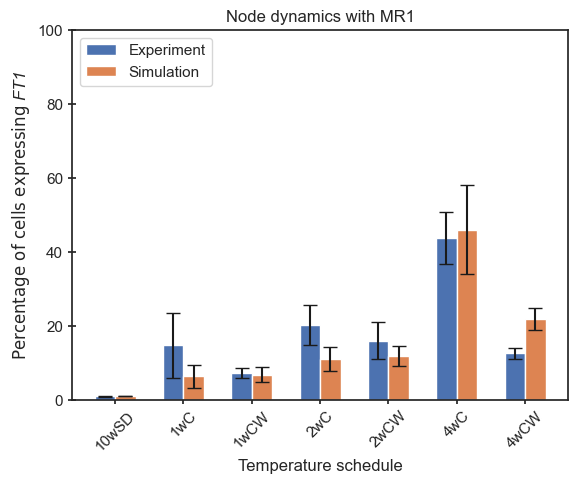

In [34]:
# manual fitting

labels = ['10wSD', '1wC', '1wCW', '2wC', '2wCW', '4wC', '4wCW']
# labels = ['10 weeks of short days', '1 week cold', '1 week of cold/warm', '2 weeks of cold', '2 weeks of cold/warm', '4 weeks of cold', '4 weeks of cold/warm']
# labels_cold = ['10 weeks of short days', '1 week cold', '2 weeks of cold', '4 weeks of cold']
labels_cold = ['10wSD', '1wC', '2wC','4wC']

data_FT1 = [0.94, 14.78, 7.21, 20.25 , 15.94 , 43.71 , 12.62]
yerr_exp = [0.12, 8.8, 1.29, 5.36, 5, 7, 1.5]



sim = [1 , 6.3, 6.74, 11,11.8, 46, 21.8]
yerr_sim = [0 ,3 , 2, 3.15 , 2.8 , 12 ,3]

data_FT1_cold = [0.94, 14.78, 20.25, 43.71]
data_FT1_cold_err = [0.12, 8.8, 5.36, 7]


sim_cold1 = [1, 7.65, 15.04, 100] # p_cold = 0.0004
sim_cold1_err = [0, 2, 1, 0]

sim_cold2 = [1, 6.28, 11.17,46] # p_cold =  0.0003
sim_cold2_err = [0, 2, 1, 10]

sim_cold3 = [1, 6.71, 13.4, 77.7] # p_cold =  0.00035
sim_cold3_err = [0, 2, 1, 13]

sim_cold4 = [1, 9.29, 23.45, 100] # p_cold = 0.0005
sim_cold4_err = [0, 2, 5, 0]

sim_cold5 = [1, 5.28, 9.32, 23.13 ] # p_cold = 0.00025
sim_cold5_err = [0, 0.5, 2, 10]

sim_cold6 = [1, 4.11, 8.28, 17 ] # p_cold = 0.0002
sim_cold6_err = [0, 0.5, 3, 10]

sim_cold7 = [1, 6.27, 11.38,41.54] # p_cold = 0.000291
sim_cold7_err = [0, 0.5, 2, 10]

x = np.arange(len(labels))  # the label locations
x_axis = np.arange(len(labels))

# Multi bar Chart

sns.set()
sns.set_style("white")
fig, ax = plt.subplots()

# ax.bar(x_axis, data_FT1_cold, yerr = data_FT1_cold_err, width = 0.4, label = 'Experiment', capsize=10)

ax.bar(x_axis-0.15, data_FT1, yerr = yerr_exp, width = 0.3,label = 'Experiment', capsize= 5)
ax.bar(x_axis+0.15, sim, yerr = yerr_sim, width=0.3, label = 'Simulation', capsize= 5)

ax.set_ylabel(r"$\rm{Percentage\ of\ cells\ expressing}$ FT1", font = "Arial", style = 'italic')
ax.set_xlabel("Temperature schedule")
# ax.set_title('Fitting simulations with FT1 RT-PCR data, using MR0', font = "Arial")
ax.set_title('Node dynamics with MR1', font = "Arial")
plt.xticks(x_axis, labels, rotation = 45)
ax.tick_params(bottom = True, left = True, direction="inout")
plt.legend(loc='upper left')
ax.set_ylim(0, 100)

fig.savefig("node_dyn.png", dpi = 600, bbox_inches = 'tight')
plt.show()

In [ ]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

sns.set()
sns.set_style("white")
fig, ax = plt.subplots()

ax.set_ylabel(r"Mean square error viz. MSE (p)", font = "Arial")
ax.set_xlabel(r"p (p_node_cold)", font = "Arial")
ax.set_title(r"MSE(p) Vs. p for contant cold - FT1 data", font = "Arial", fontsize = 13)

ax.plot(df1['p'], df1['mse_p'], color = '#4daf4a', label = "range of p = (0.000280, 0.0000290)")

ax.tick_params(bottom = True, left = True, direction="inout")
ax.set_ylim(0,)
ax.set_xlim(0.000279, 0.000300)
ax.legend(loc = "upper left")
plt.xticks(fontsize=8)


plt.show()
# fig.savefig("p_mse_3.png", dpi = 600)